In [3]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score
import os
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap


/var/folders/zg/ds4nwmvx3kq28hn4r4zwbbw80000gp/T/ipykernel_98572/3827359723.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [4]:
ds_version = "V1_0"
annotations_file = "streetSurfaceVis_v1_0.csv"
pred_file_type = "RTK_complete_lmh-crop_type_prediction-V1_0_annotated-20240815_125314.csv"
pred_file_asphalt = "RTK_complete_lmh-crop_quality_asphalt_prediction-V1_0_annotated_asphalt-20240815_125401.csv"
pred_file_concrete = "RTK_complete_lmh-crop_quality_concrete_prediction-V1_0_annotated_concrete-20240815_125415.csv"
pred_file_paving_stones = "RTK_complete_lmh-crop_quality_paving_stones_prediction-V1_0_annotated_paving_stones-20240815_125445.csv"
pred_file_sett = "RTK_complete_lmh-crop_quality_sett_prediction-V1_0_annotated_sett-20240815_125506.csv"
pred_file_unpaved = "RTK_complete_lmh-crop_quality_unpaved_prediction-V1_0_annotated_unpaved-20240815_125524.csv"

root_data_path = os.path.join("..", "data", ds_version) # TODO: prediction folder, see prediction file
data_path = os.path.join(root_data_path, "metadata") # TODO: prediction folder, see prediction file

In [5]:
pred = pd.DataFrame()

# print(f"reading {pred_file}")
pred = pd.read_csv(os.path.join(data_path, pred_file_type))
pred.rename(columns={"Image": "image_id",  "Level_0": "type_pred"}, inplace=True)

type_pred = pred[["image_id", "Prediction", "type_pred", "is_in_validation"]]
type_pred.rename(columns={"Prediction": "class_prob"}, inplace=True)
idx = type_pred.groupby("image_id")["class_prob"].idxmax()
type_pred = type_pred.loc[idx]

asphalt_pred = pd.read_csv(os.path.join(data_path, pred_file_asphalt))
concrete_pred = pd.read_csv(os.path.join(data_path, pred_file_concrete))
paving_stones_pred = pd.read_csv(os.path.join(data_path, pred_file_paving_stones))
sett_pred = pd.read_csv(os.path.join(data_path, pred_file_sett))
unpaved_pred = pd.read_csv(os.path.join(data_path, pred_file_unpaved))

quality_pred = pd.concat([
    asphalt_pred,
    concrete_pred,
    paving_stones_pred,
    sett_pred,
    unpaved_pred,
], ignore_index=True)
quality_pred.rename(columns={"Image": "image_id",  "Level_0": "quality_pred"}, inplace=True)
quality_pred = quality_pred[["image_id", "Prediction", "quality_pred", "is_in_validation"]]
quality_pred.rename(columns={"Prediction": "quality_float_pred"}, inplace=True)

pred = quality_pred.set_index("image_id").join(type_pred.set_index("image_id"), lsuffix="_quality", rsuffix="_type")

/var/folders/zg/ds4nwmvx3kq28hn4r4zwbbw80000gp/T/ipykernel_98572/1087077349.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  type_pred.rename(columns={"Prediction": "class_prob"}, inplace=True)


In [6]:
pred

,quality_float_pred,quality_pred,is_in_validation_quality,class_prob,type_pred,is_in_validation_type
image_id,,,,,,
1034408953632837,2.352533,good,0,0.995532,asphalt,0
1100265047387442,2.521562,regular,0,0.999229,asphalt,0
110578584434317,2.058117,good,0,0.958966,asphalt,0
1108901116248517,2.705905,regular,0,0.999851,asphalt,0
1113333976148346,2.188903,good,0,0.999946,asphalt,0
...,...,...,...,...,...,...
949628032537945,2.110430,outside,0,0.999987,paved,0
957174672610848,1.416984,outside,0,0.996045,paved,0
958816501528783,2.152495,outside,0,0.994132,asphalt,0


In [18]:
annot = pd.read_csv(os.path.join(root_data_path, annotations_file))
annot.rename(columns={"mapillary_image_id": "image_id", "surface_type": "type_true", "surface_quality": "quality_true"}, inplace=True)
annot["type_true"] = annot["type_true"].replace({'asphalt': 'asphalt-concrete', 'concrete': 'asphalt-concrete', 'paving_stones': 'paving_stones-sett', 'sett': 'paving_stones-sett'})
annot["quality_float_true"] = annot["quality_true"].map({"excellent": 1, "good": 2, "intermediate": 3, "bad": 4, "very_bad": 5})

In [19]:
annot

,image_id,user_id,user_name,captured_at,longitude,latitude,train,type_true,quality_true,quality_float_true
0,1000927687276860,103606985215406,dsmm,1655735677353,13.287805,51.502597,True,asphalt-concrete,intermediate,3
1,1001349260556407,102468835332129,ber319,1659015876793,14.426536,52.217757,True,unpaved,bad,4
2,1001419624308587,100232345559807,carlheinz,1698249177500,13.457938,52.512914,True,asphalt-concrete,good,2
3,1001712924422413,100232345559807,carlheinz,1699107239000,13.386874,52.564970,True,asphalt-concrete,excellent,1
4,1001853784055707,102627028648372,kartonage,1652268883000,13.389880,52.546260,True,asphalt-concrete,excellent,1
...,...,...,...,...,...,...,...,...,...,...
9117,435956961754271,103080845264750,teddy73,1657610360090,9.227063,49.181487,False,asphalt-concrete,good,2
9118,152523294419317,103080845264750,teddy73,1681130193000,9.179631,49.120123,False,asphalt-concrete,excellent,1
9119,303366287999275,100562292188203,changchun1,1612977717350,9.172729,49.106565,False,unpaved,bad,4
9120,563555448482947,100562292188203,changchun1,1654801255232,9.176029,49.098283,False,asphalt-concrete,excellent,1


In [20]:
df = pred.join(
    annot[["image_id", "type_true", "quality_true", "quality_float_true"]].set_index("image_id"), how="left")

In [37]:
import numpy as np
print(f"all: {np.corrcoef(df.quality_float_true, df.quality_float_pred)[0, 1]}")
# distinguish by type?

# only type prediction true

all: 0.006909930877385273


In [39]:
# print(np.corrcoef(df[df.type_true == "asphalt"].quality_float_true, df[df.type_true == "asphalt"].quality_float_pred))
# print(np.corrcoef(df[df.type_true == "concrete"].quality_float_true, df[df.type_true == "concrete"].quality_float_pred))
# print(np.corrcoef(df[df.type_true == "paving_stones"].quality_float_true, df[df.type_true == "paving_stones"].quality_float_pred))
# print(np.corrcoef(df[df.type_true == "sett"].quality_float_true, df[df.type_true == "sett"].quality_float_pred))
print(f"asphalt: {np.corrcoef(df[df.type_true == 'asphalt-concrete'].quality_float_true, df[df.type_true == 'asphalt-concrete'].quality_float_pred)[0, 1]}")
print(f"paved: {np.corrcoef(df[df.type_true == 'paving_stones-sett'].quality_float_true, df[df.type_true == 'paving_stones-sett'].quality_float_pred)[0, 1]}")
print(f"unpaved: {np.corrcoef(df[df.type_true == 'unpaved'].quality_float_true, df[df.type_true == 'unpaved'].quality_float_pred)[0, 1]}")

asphalt: 0.20846045228762713
paved: -0.009282015462894058
unpaved: -0.12111976980051631


In [40]:
from scipy.stats import pearsonr, spearmanr

pearson_corr, pearson_p_value = pearsonr(df.quality_float_true, df.quality_float_pred)

spearman_corr, spearman_p_value = spearmanr(df.quality_float_true, df.quality_float_pred)

print(f"all\n{pearson_corr}")
print(pearson_p_value)

print(spearman_corr)
print(spearman_p_value)

all/n0.006909930877385285
0.5279230335134186
0.2454641043392141
8.970963342590646e-115


In [46]:
from scipy.stats import pearsonr, spearmanr

classes = df['type_true'].unique()
quality_corr_list = []

for cls in classes:
    class_df = df[df['type_true'] == cls]
    pearson_corr, pearson_p_value = pearsonr(class_df.quality_float_true, class_df.quality_float_pred)
    spearman_corr, spearman_p_value = spearmanr(class_df.quality_float_true, class_df.quality_float_pred)
    
    quality_corr_list.append({
        'Class': cls,
        'Pearson_Coefficient': pearson_corr,
        'Pearson_p_value': pearson_p_value,
        'Spearman_Coefficient': spearman_corr,
        'Spearman_p_value': spearman_p_value
    })

# Berechne die Korrelationskoeffizienten und p-Werte für alle Daten zusammen
pearson_corr, pearson_p_value = pearsonr(df.quality_float_true, df.quality_float_pred)
spearman_corr, spearman_p_value = spearmanr(df.quality_float_true, df.quality_float_pred)

# Füge die Gesamtwerte zur Tabelle hinzu
quality_corr_list.append({
    'Class': 'Overall',
    'Pearson_Coefficient': pearson_corr,
    'Pearson_p_value': pearson_p_value,
    'Spearman_Coefficient': spearman_corr,
    'Spearman_p_value': spearman_p_value
})

quality_corr_results = pd.DataFrame(quality_corr_list)


# Ausgabe der Ergebnisse
print(quality_corr_results)


                Class  Pearson_Coefficient  Pearson_p_value  \
0    asphalt-concrete             0.208460     4.539427e-42   
1  paving_stones-sett            -0.009282     5.965480e-01   
2             unpaved            -0.121120     2.119566e-04   
3             Overall             0.006910     5.279230e-01   

   Spearman_Coefficient  Spearman_p_value  
0              0.201041      3.434664e-39  
1             -0.131257      5.551616e-14  
2             -0.133933      4.138486e-05  
3              0.245464     8.970963e-115  


In [30]:
from sklearn.metrics import classification_report

report = classification_report(df['type_true'].replace({'asphalt-concrete': 'asphalt', 'paving_stones-sett': 'paved'}), df['type_pred'])
print(report)

              precision    recall  f1-score   support

     asphalt       0.76      0.95      0.85      4160
       paved       0.81      0.77      0.79      3255
     unpaved       0.88      0.11      0.19       931

    accuracy                           0.78      8346
   macro avg       0.82      0.61      0.61      8346
weighted avg       0.80      0.78      0.75      8346



In [23]:
df

,quality_float_pred,quality_pred,is_in_validation_quality,class_prob,type_pred,is_in_validation_type,type_true,quality_true,quality_float_true
image_id,,,,,,,,,
1034408953632837,2.352533,good,0,0.995532,asphalt,0,asphalt-concrete,bad,4
1100265047387442,2.521562,regular,0,0.999229,asphalt,0,asphalt-concrete,bad,4
110578584434317,2.058117,good,0,0.958966,asphalt,0,asphalt-concrete,bad,4
1108901116248517,2.705905,regular,0,0.999851,asphalt,0,asphalt-concrete,bad,4
1113333976148346,2.188903,good,0,0.999946,asphalt,0,asphalt-concrete,bad,4
...,...,...,...,...,...,...,...,...,...
949628032537945,2.110430,outside,0,0.999987,paved,0,unpaved,very_bad,5
957174672610848,1.416984,outside,0,0.996045,paved,0,unpaved,very_bad,5
958816501528783,2.152495,outside,0,0.994132,asphalt,0,unpaved,very_bad,5


In [24]:
df.groupby(["type_true", "quality_true"]).size()

type_true           quality_true
asphalt-concrete    bad              296
                    excellent       1101
                    good            1747
                    intermediate    1016
paving_stones-sett  bad              596
                    excellent        360
                    good            1117
                    intermediate    1182
unpaved             bad              339
                    intermediate     305
                    very_bad         287
dtype: int64

In [25]:
df.shape

(8346, 9)

## Surface type

Text(58.08159722222221, 0.5, 'true type')

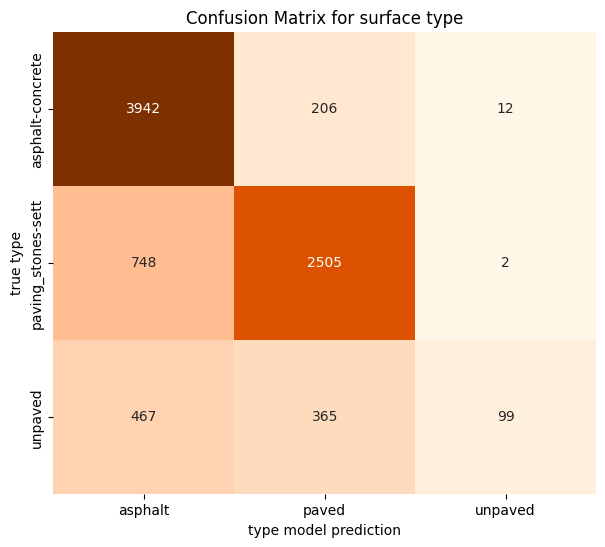

In [26]:
# # confusion matrix for all model surface types
# cmap = LinearSegmentedColormap.from_list("mycmap", ["#FFF6E8", "#FF5F00", "#7F3000"])

# # labels_type_true = df.type_true.unique()
# # labels_type_pred = df.type_pred.unique()
# labels = ['asphalt', 'concrete', 'paving_stones', 'sett', 'paved', 'unpaved']

# cm = confusion_matrix(df.type_true, df.type_pred, labels=labels)
# cm_df = pd.DataFrame(cm, index=labels, columns=labels)
# cm_df = cm_df[['asphalt', 'paved', 'unpaved']]
# cm_df = cm_df.loc[['asphalt', 'concrete', 'paving_stones', 'sett', 'unpaved']]
# # plt.figure()
# # sns.heatmap(cm_df, annot=True, fmt="d", cmap=cmap, cbar=False,
# #             xticklabels=['asphalt', 'concrete', 'paving_stones', 'sett', 'unpaved'],
# #             yticklabels=['asphalt', 'paved', 'unpaved'])
# # plt.title(f"Confusion Matrix for surface type")
# # plt.xlabel("type model prediction")
# # plt.ylabel("true type")
# fig, axes = plt.subplots(1, 1, figsize=(7, 6))

# # Confusion Matrix für Surface Type
# sns.heatmap(cm_df, annot=True, fmt="d", cmap=cmap, cbar=False,
#             xticklabels=['asphalt', 'paved', 'unpaved'],
#             yticklabels=['asphalt', 'concrete', 'paving_stones', 'sett', 'unpaved'],
#             ax=axes)
# axes.set_title(f"Confusion Matrix for surface type")
# axes.set_xlabel("type model prediction")
# axes.set_ylabel("true type")

# confusion matrix for all model surface types
cmap = LinearSegmentedColormap.from_list("mycmap", ["#FFF6E8", "#FF5F00", "#7F3000"])

# labels_type_true = df.type_true.unique()
# labels_type_pred = df.type_pred.unique()
labels = ['asphalt', 'asphalt-concrete', 'paving_stones-sett', 'paved', 'unpaved']

cm = confusion_matrix(df.type_true, df.type_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
cm_df = cm_df[['asphalt', 'paved', 'unpaved']]
cm_df = cm_df.loc[['asphalt-concrete', 'paving_stones-sett', 'unpaved']]
# plt.figure()
# sns.heatmap(cm_df, annot=True, fmt="d", cmap=cmap, cbar=False,
#             xticklabels=['asphalt', 'concrete', 'paving_stones', 'sett', 'unpaved'],
#             yticklabels=['asphalt', 'paved', 'unpaved'])
# plt.title(f"Confusion Matrix for surface type")
# plt.xlabel("type model prediction")
# plt.ylabel("true type")
fig, axes = plt.subplots(1, 1, figsize=(7, 6))

# Confusion Matrix für Surface Type
sns.heatmap(cm_df, annot=True, fmt="d", cmap=cmap, cbar=False,
            xticklabels=['asphalt', 'paved', 'unpaved'],
            yticklabels=['asphalt-concrete', 'paving_stones-sett', 'unpaved'],
            ax=axes)
axes.set_title(f"Confusion Matrix for surface type")
axes.set_xlabel("type model prediction")
axes.set_ylabel("true type")

Text(58.0815972222222, 0.5, 'true type')

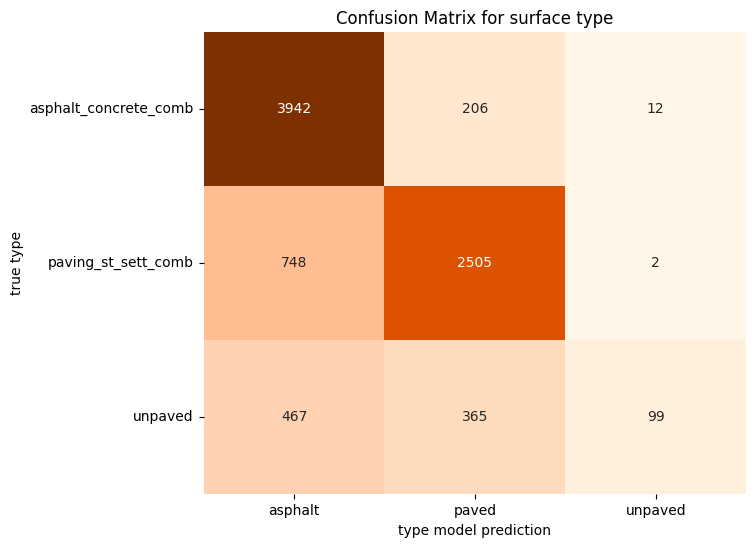

In [16]:
# # confusion matrix for combined surface types
# fig, axes = plt.subplots(1, 1, figsize=(7, 6))

# cm_df.loc['asphalt_concrete_comb'] = cm_df.loc['asphalt'] + cm_df.loc['concrete']
# cm_df.loc['paving_st_sett_comb'] = cm_df.loc['paving_stones'] + cm_df.loc['sett']
# cm_df = cm_df.loc[['asphalt_concrete_comb', 'paving_st_sett_comb', 'unpaved']]
# # plt.figure()
# sns.heatmap(cm_df, annot=True, fmt="d", cmap=cmap, cbar=False,
#             xticklabels=['asphalt', 'paved', 'unpaved'],
#             yticklabels=['asphalt_concrete_comb', 'paving_st_sett_comb', 'unpaved'],
#             ax=axes)
# axes.set_title(f"Confusion Matrix for surface type")
# axes.set_xlabel("type model prediction")
# axes.set_ylabel("true type")

In [28]:
overall_accuracy = cm_df.values.trace() / cm_df.values.sum()

class_precision = cm_df.rename(index={'asphalt-concrete': 'asphalt', 'paving_stones-sett': 'paved'}).apply(lambda x: x[x.name] / x.sum(), axis=1)

print("Recall per class:")
print(class_precision)

print(f"\nAccuracy: {overall_accuracy:.2f}")


Recall per class:
asphalt    0.947596
paved      0.769585
unpaved    0.106337
dtype: float64

Accuracy: 0.78


## Surface Quality

Text(58.081597222222214, 0.5, 'true quality')

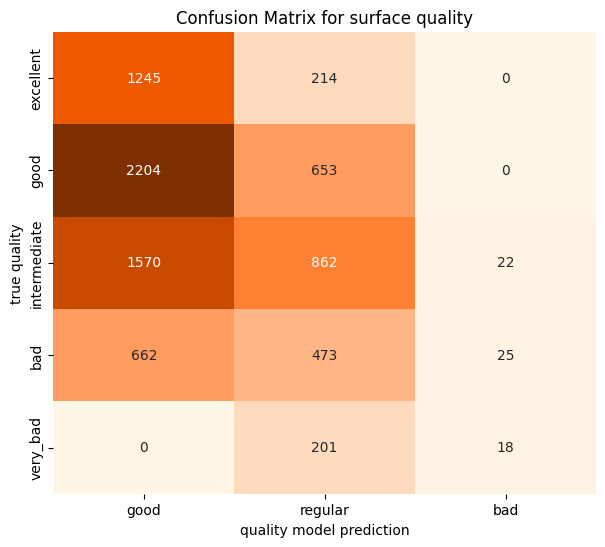

In [18]:
# confusion matrix for all model surface types
cmap = LinearSegmentedColormap.from_list("mycmap", ["#FFF6E8", "#FF5F00", "#7F3000"])

# labels_type_true = df.type_true.unique()
# labels_type_pred = df.type_pred.unique()
labels = ['excellent', 'good', 'intermediate', 'regular', 'bad', 'very_bad']

fig, axes = plt.subplots(1, 1, figsize=(7, 6))

cm = confusion_matrix(df.quality_true, df.quality_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
cm_df = cm_df.loc[['excellent', 'good', 'intermediate', 'bad', 'very_bad']]
cm_df = cm_df[['good', 'regular', 'bad']]
sns.heatmap(cm_df, annot=True, fmt="d", cmap=cmap, cbar=False,
            xticklabels=['good', 'regular', 'bad'],
            yticklabels=['excellent', 'good', 'intermediate', 'bad', 'very_bad'],
            ax=axes)
axes.set_title(f"Confusion Matrix for surface quality")
axes.set_xlabel("quality model prediction")
axes.set_ylabel("true quality")

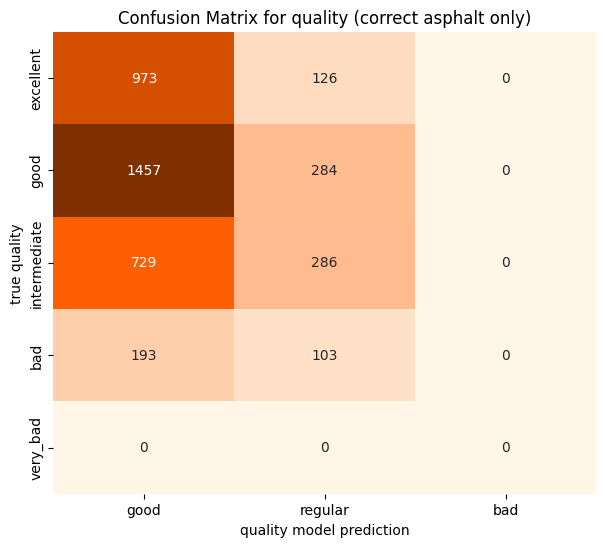

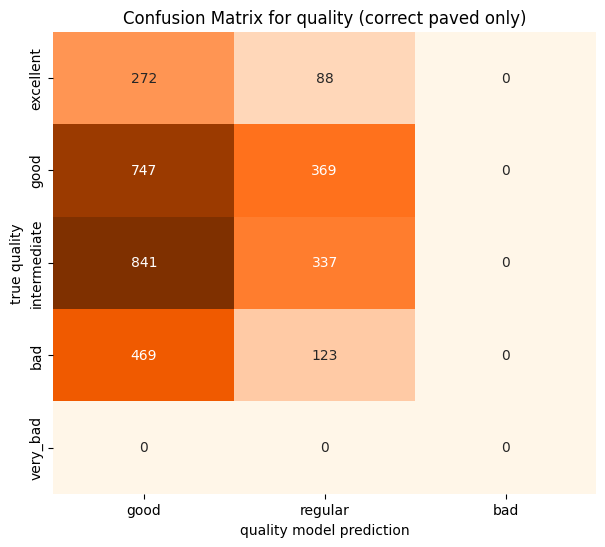

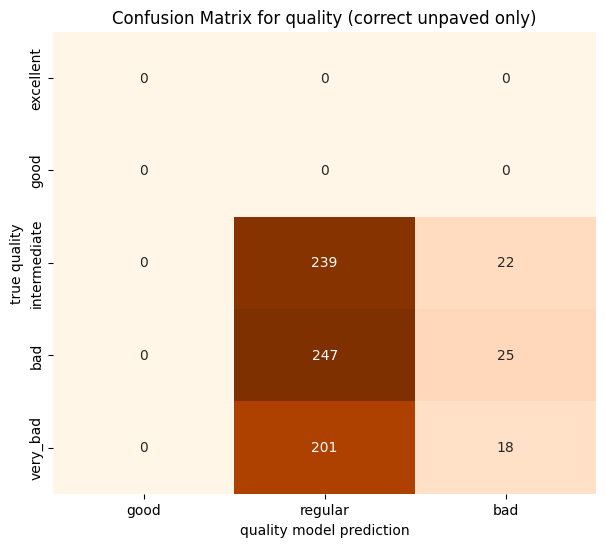

In [47]:
# confusion matrix for all model surface types
cmap = LinearSegmentedColormap.from_list("mycmap", ["#FFF6E8", "#FF5F00", "#7F3000"])

# labels_type_true = df.type_true.unique()
# labels_type_pred = df.type_pred.unique()
labels = ['excellent', 'good', 'intermediate', 'regular', 'bad', 'very_bad']

fig, axes = plt.subplots(1, 1, figsize=(7, 6))

cm = confusion_matrix(df[(df.type_true == 'asphalt-concrete')].quality_true, df[(df.type_true == 'asphalt-concrete')].quality_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
cm_df = cm_df.loc[['excellent', 'good', 'intermediate', 'bad', 'very_bad']]
cm_df = cm_df[['good', 'regular', 'bad']]
sns.heatmap(cm_df, annot=True, fmt="d", cmap=cmap, cbar=False,
            xticklabels=['good', 'regular', 'bad'],
            yticklabels=['excellent', 'good', 'intermediate', 'bad', 'very_bad'],
            ax=axes)
axes.set_title(f"Confusion Matrix for quality (correct asphalt only)")
axes.set_xlabel("quality model prediction")
axes.set_ylabel("true quality")

plt.show()

fig, axes = plt.subplots(1, 1, figsize=(7, 6))

cm = confusion_matrix(df[(df.type_true == 'paving_stones-sett')].quality_true, df[(df.type_true == 'paving_stones-sett')].quality_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
cm_df = cm_df.loc[['excellent', 'good', 'intermediate', 'bad', 'very_bad']]
cm_df = cm_df[['good', 'regular', 'bad']]
sns.heatmap(cm_df, annot=True, fmt="d", cmap=cmap, cbar=False,
            xticklabels=['good', 'regular', 'bad'],
            yticklabels=['excellent', 'good', 'intermediate', 'bad', 'very_bad'],
            ax=axes)
axes.set_title(f"Confusion Matrix for quality (correct paved only)")
axes.set_xlabel("quality model prediction")
axes.set_ylabel("true quality")

plt.show()

fig, axes = plt.subplots(1, 1, figsize=(7, 6))

# TODO
cm = confusion_matrix(df[(df.type_true == 'unpaved')].quality_true, df[(df.type_true == 'unpaved')].quality_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
cm_df = cm_df.loc[['excellent', 'good', 'intermediate', 'bad', 'very_bad']]
cm_df = cm_df[['good', 'regular', 'bad']]
sns.heatmap(cm_df, annot=True, fmt="d", cmap=cmap, cbar=False,
            xticklabels=['good', 'regular', 'bad'],
            yticklabels=['excellent', 'good', 'intermediate', 'bad', 'very_bad'],
            ax=axes)
axes.set_title(f"Confusion Matrix for quality (correct unpaved only)")
axes.set_xlabel("quality model prediction")
axes.set_ylabel("true quality")

plt.show()

## Measures for quality by surface type

In [31]:
def compute_measures_cat(true, pred):
    return{
        "accuracy": sum(true == pred) / len(true)
    }

def compute_measures_float(true_float, pred_float):
    m = {
    "accuracy": sum(true_float.round() == pred_float.round()) / len(true_float),
    "correlation": np.corrcoef(true_float, pred_float)[0, 1],
    "r_square": r2_score(true_float, pred_float),
    "mse": mean_squared_error(true_float, pred_float),
    "mae": mean_absolute_error(true_float, pred_float)
    }
    m["rmse"] = np.sqrt(m["mse"])
    return m

In [32]:
gm_surface = pd.DataFrame()
for surface in df.type_true.unique():
    df_ = df[df.type_true == surface]
    gm = compute_measures_float(df_.quality_float_true, df_.quality_float_pred)
    gm_surface = pd.concat([gm_surface, pd.Series(gm, name=surface)], axis=1)

gm_surface.round(2)

,asphalt,concrete,paving_stones,sett,unpaved
accuracy,0.45,0.33,0.45,0.16,0.28
correlation,0.26,0.07,-0.00,0.03,-0.12
r_square,0.05,-0.14,-950.80,-35.73,-2.31
mse,0.73,0.93,545.54,14.76,2.10
mae,0.69,0.82,1.20,1.23,1.17
rmse,0.85,0.97,23.36,3.84,1.45


## compare float values

In [48]:
df_wo_outliers = df[(df["quality_float_pred"] >= 0) & (df["quality_float_pred"] <= 6)]

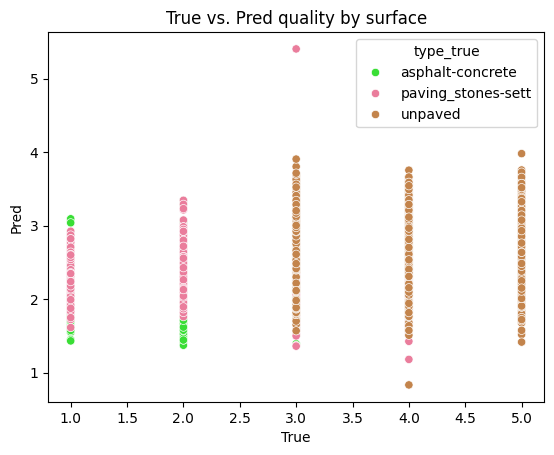

In [49]:
# Plot
np.random.seed(5)
colors = {surface_type: np.random.rand(3,) for surface_type in df.type_true.unique()}

sns.scatterplot(data=df_wo_outliers, x="quality_float_true", y="quality_float_pred", hue="type_true", palette=colors, legend="full", )
plt.xlabel('True')
plt.ylabel('Pred')
plt.title('True vs. Pred quality by surface')
plt.show()


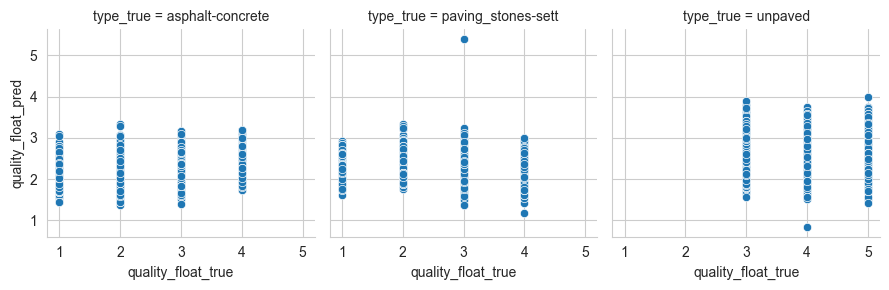

In [50]:
sns.set_style("whitegrid")

# Create a FacetGrid
g = sns.FacetGrid(df_wo_outliers, col="type_true", col_wrap=3)

# Map scatter plot for each surface type
g.map(sns.scatterplot, "quality_float_true", "quality_float_pred")

plt.show()

#### Hom much do the deviate?

In [ ]:
df_valid_quality.loc[:,"deviation"] = df_valid_quality.quality_float_true - df_valid_quality.quality_float_pred

**Overall**

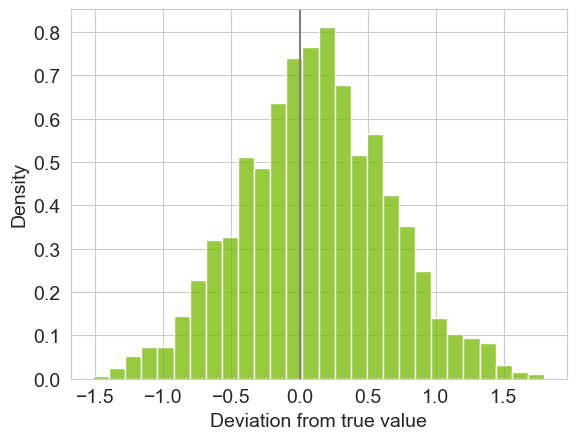

In [ ]:
sns.histplot(df_valid_quality, color='#76B900', stat="density", x="deviation")
plt.xlabel("Deviation from true value")
plt.axvline(x=0, color="grey")
plt.savefig("deviation_hist_quality_V1_0.png", transparent=True)
plt.show()


In [ ]:
np.mean(df_valid_quality.deviation)

0.1149677615464645

In [ ]:
np.std(df_valid_quality.deviation)


0.5403729757753959

In [ ]:
(abs(df_valid_quality.deviation) >= 1).value_counts()

deviation
False    1515
True      120
Name: count, dtype: int64

In [ ]:
120/len(df_valid_quality)

0.07339449541284404

**by surface**

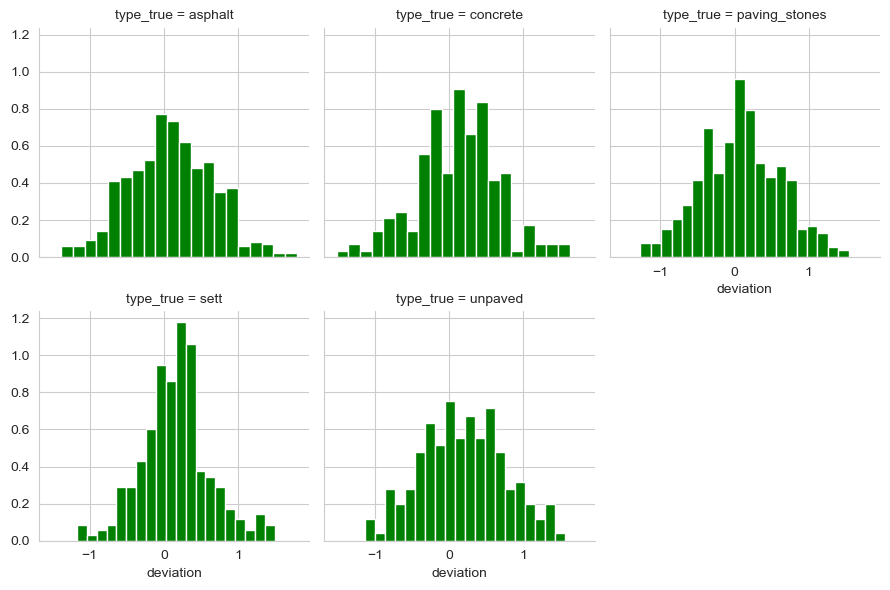

In [ ]:
# Create a FacetGrid for histograms
g_hist = sns.FacetGrid(df_valid_quality, col="type_true", col_wrap=3)

# Map histogram for deviation for each surface type
g_hist.map(plt.hist, "deviation", color='green', density=True, bins=20)

plt.show()

## compare classes

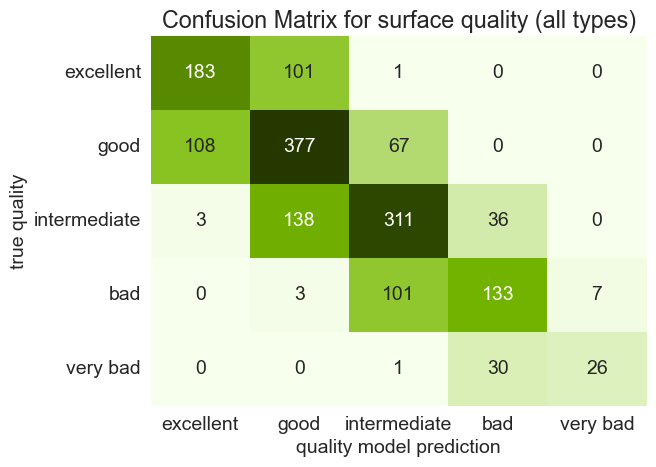

In [ ]:
# only validation
# Plotting the confusion matrix using seaborn heatmap
cmap = LinearSegmentedColormap.from_list("mycmap", ["#F7FFED", "#76B900", "#355300", "#243800"])

cm = confusion_matrix(df_valid_quality.quality_true, df_valid_quality.quality_pred, labels=["excellent", "good", "intermediate", "bad", "very_bad"])
plt.figure()
sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, cbar=False,
            xticklabels=["excellent", "good", "intermediate", "bad", "very bad"],
            yticklabels=["excellent", "good", "intermediate", "bad", "very bad"])
plt.title(f"Confusion Matrix for surface quality (all types)")
plt.xlabel("quality model prediction")
plt.ylabel("true quality")
plt.savefig("confusion_matrix_quality_v1_0.png", transparent=True, bbox_inches='tight')
plt.show()

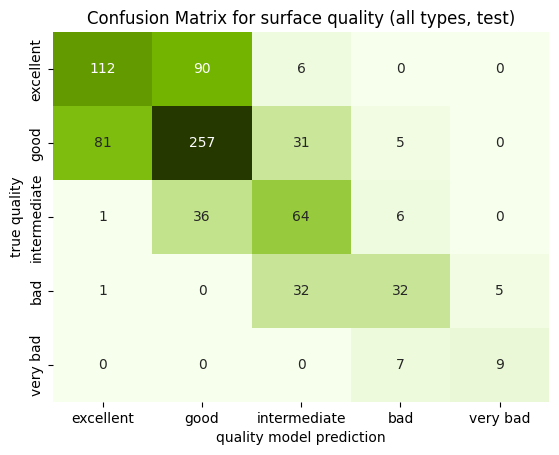

In [ ]:
# only validation
# Plotting the confusion matrix using seaborn heatmap
cmap = LinearSegmentedColormap.from_list("mycmap", ["#F7FFED", "#76B900", "#355300", "#243800"])

cm = confusion_matrix(df_test.quality_true, df_test.quality_pred, labels=["excellent", "good", "intermediate", "bad", "very_bad"])
plt.figure()
sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, cbar=False,
            xticklabels=["excellent", "good", "intermediate", "bad", "very bad"],
            yticklabels=["excellent", "good", "intermediate", "bad", "very bad"])
plt.title(f"Confusion Matrix for surface quality (all types, test)")
plt.xlabel("quality model prediction")
plt.ylabel("true quality")
plt.savefig("confusion_matrix_quality_v1_0_test.png", transparent=True, bbox_inches='tight')
plt.show()

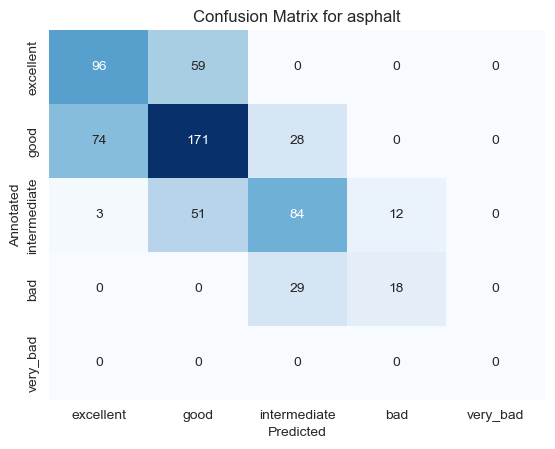

<Figure size 640x480 with 0 Axes>

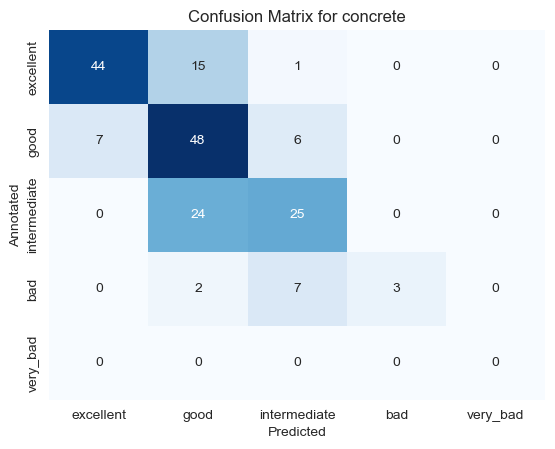

<Figure size 640x480 with 0 Axes>

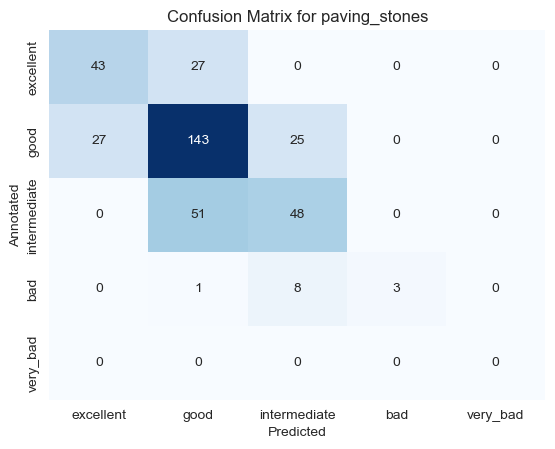

<Figure size 640x480 with 0 Axes>

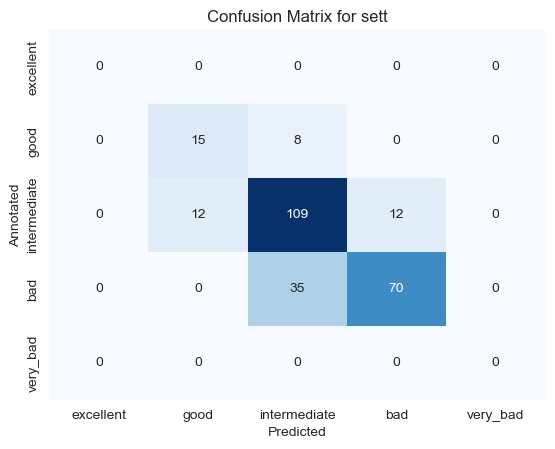

<Figure size 640x480 with 0 Axes>

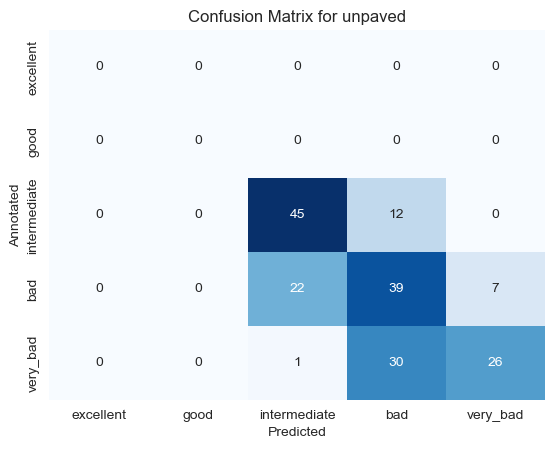

<Figure size 640x480 with 0 Axes>

In [ ]:
# only validation
# Plotting the confusion matrix using seaborn heatmap
for surface in df_valid_quality.type_true.unique():
    _df = df_valid_quality[(df_valid_quality.type_true == surface)]
    cm = confusion_matrix(_df.quality_true, _df.quality_pred, labels=["excellent", "good", "intermediate", "bad", "very_bad"])
    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["excellent", "good", "intermediate", "bad", "very_bad"],
                yticklabels=["excellent", "good", "intermediate", "bad", "very_bad"])
    plt.title(f"Confusion Matrix for {surface}")
    plt.xlabel("Predicted")
    plt.ylabel("Annotated")
    plt.show()



In [ ]:
# Extract predicted and ground truth values
precisions = []
recalls = []
f1scores = []
for class_name in df_valid_type['type_true'].unique():
    _df1 = df_valid_type[df_valid_type['type_pred'] == class_name]
    _df2 = df_valid_type[df_valid_type['type_true'] == class_name]
    class_precision = sum(_df1.type_true == class_name) / len(_df1)
    class_recall = sum(_df2.type_pred == class_name) / len(_df2)
    f1score = 2 * (class_precision * class_recall) / (class_precision + class_recall)
    precisions.append(class_precision)
    recalls.append(class_recall)
    f1scores.append(f1score)

    print(f"Class: {class_name}")t
    print(f"Count (pred): {len(_df1)}")
    print(f"Count (true): {len(_df2)}")
    print(f"Precision: {round(class_precision, 2)}")
    print(f"Recall: {round(class_recall, 2)}")
    print("------------------------")

print("------------------------")
print("------------------------")

print(f"Average precision: {round(np.mean(precisions), 2)}")
print(f"Average recall: {round(np.mean(recalls), 2)}")
print(f"Average F1-Score: {round(np.mean(f1scores), 2)}")
print(f"Accuracy: {round(sum(df_valid_type.type_true == df_valid_type.type_pred) / len(df_valid_type), 2)}")

Class: asphalt
Count (pred): 631
Count (true): 641
Precision: 0.95
Recall: 0.93
------------------------
Class: concrete
Count (pred): 205
Count (true): 191
Precision: 0.8
Recall: 0.85
------------------------
Class: sett
Count (pred): 267
Count (true): 267
Precision: 0.96
Recall: 0.96
------------------------
Class: paving_stones
Count (pred): 375
Count (true): 385
Precision: 0.98
Recall: 0.95
------------------------
Class: unpaved
Count (pred): 192
Count (true): 186
Precision: 0.94
Recall: 0.97
------------------------
------------------------
------------------------
Average precision: 0.92
Average recall: 0.93
Average F1-Score: 0.93
Accuracy: 0.94
